In [1]:
#Librerias necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import joblib

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('dataclean.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.sample(3)

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,...,neighbourhood_cleansed_Villa Pueyrredon,neighbourhood_cleansed_Villa Real,neighbourhood_cleansed_Villa Riachuelo,neighbourhood_cleansed_Villa Santa Rita,neighbourhood_cleansed_Villa Soldati,neighbourhood_cleansed_Villa Urquiza,property_type_House,room_type_Private room,room_type_Shared room,bathroomtype_shared
13855,0,1,2,1,1,2,2799,3,14,4,...,0,0,0,0,0,0,0,0,0,0
249,0,1,2,1,1,2,2895,3,1125,53,...,0,0,0,0,0,0,0,0,0,0
15338,1,1,2,1,1,1,6514,2,365,3,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17059 entries, 0 to 17058
Data columns (total 85 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   host_is_superhost                         17059 non-null  int64  
 1   host_identity_verified                    17059 non-null  int64  
 2   accommodates                              17059 non-null  int64  
 3   bathrooms                                 17059 non-null  int64  
 4   bedrooms                                  17059 non-null  int64  
 5   beds                                      17059 non-null  int64  
 6   price                                     17059 non-null  int64  
 7   minimum_nights                            17059 non-null  int64  
 8   maximum_nights                            17059 non-null  int64  
 9   number_of_reviews                         17059 non-null  int64  
 10  review_scores_rating              

In [4]:
#Genero mi variable X
X=data.drop(['price'],axis=1)

#Genero la variable y
y = data['price']

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

### Linear Regression

In [5]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) 

#Predict
lr_prediction = regressor.predict(X_test)
lr_prediction_train = regressor.predict(X_train)

score = r2_score(y_test, lr_prediction)

print('LR MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, lr_prediction_train), mean_squared_error(y_test, lr_prediction)))
print('LR R^2 train: %.3f, test: %.3f' % (r2_score(y_train, lr_prediction_train),r2_score(y_test, lr_prediction)))
print('-----------------------------------------------------')


LR MSE train: 17891841.555, test: 19352166.765
LR R^2 train: 0.406, test: 0.392
-----------------------------------------------------


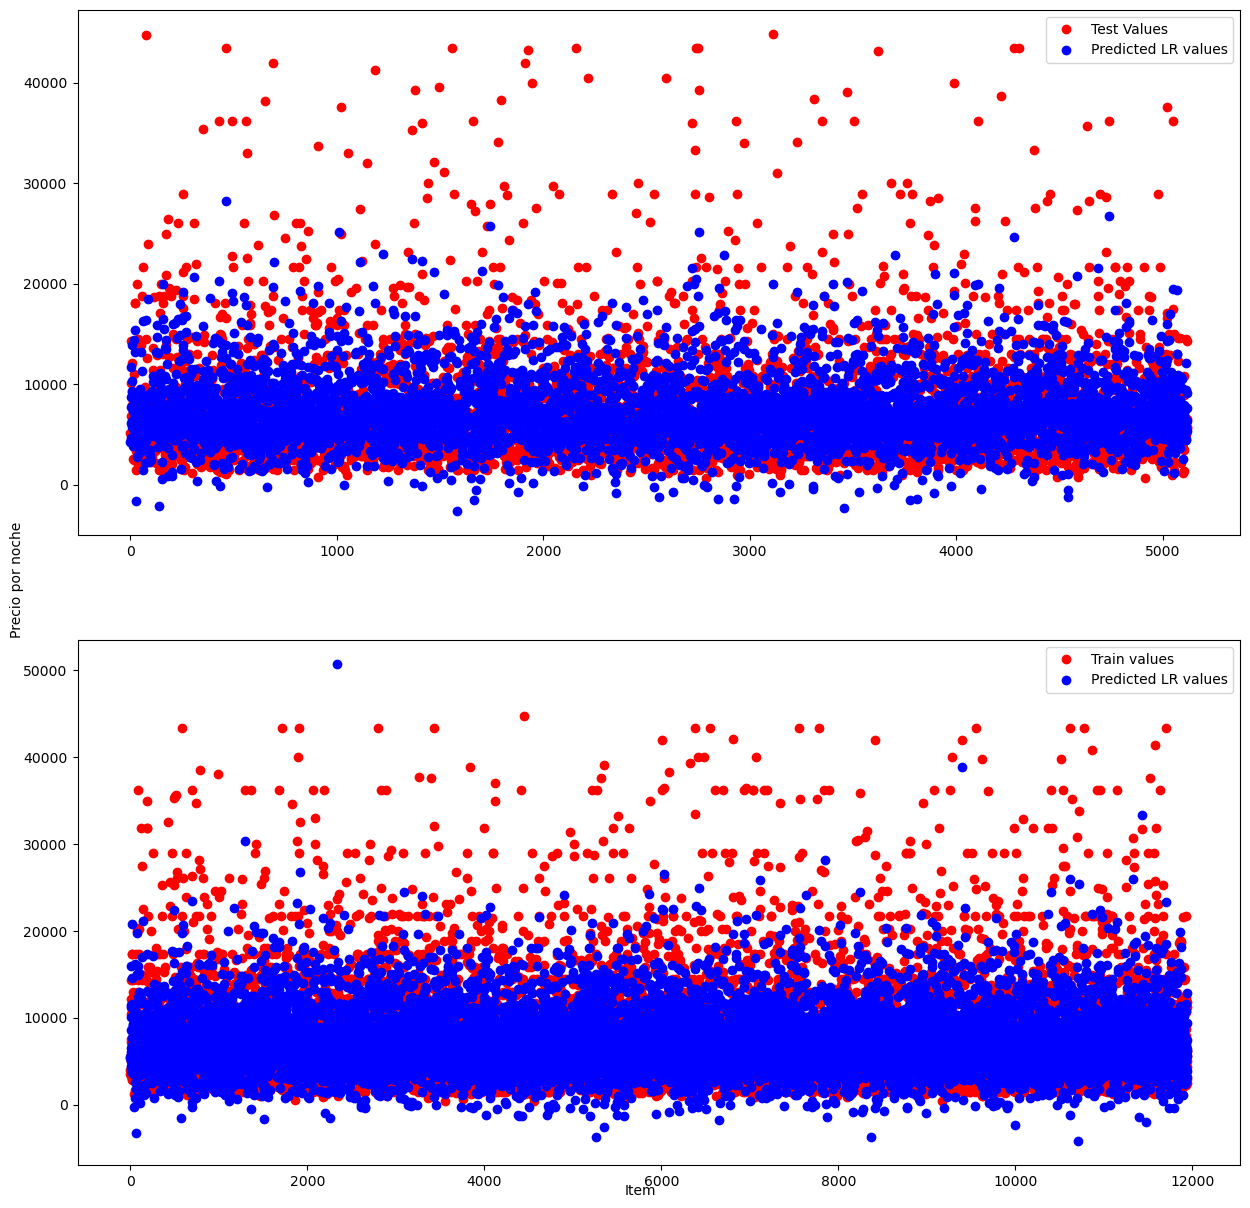

In [6]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],lr_prediction, 'bo', label="Predicted LR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],lr_prediction_train, 'bo', label="Predicted LR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

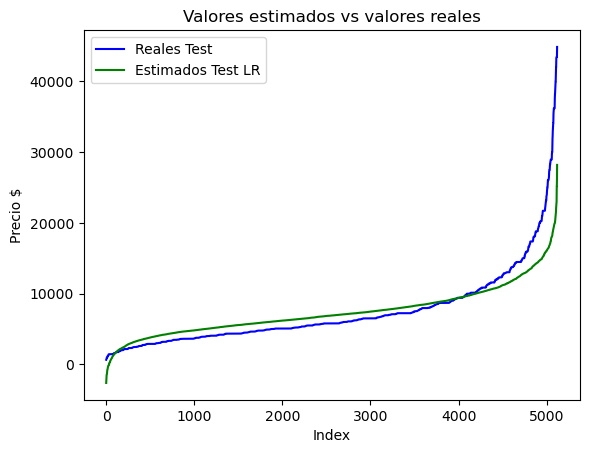

In [7]:
eje_X=range(1,len(y_test)+1)
plt.plot(eje_X, sorted(y_test), color='blue', label='Reales Test')
plt.plot(eje_X, sorted(lr_prediction), color='green', label='Estimados Test LR')
plt.legend()
plt.title('Valores estimados vs valores reales')
plt.xlabel('Index')
plt.ylabel('Precio $')
plt.show()

In [8]:
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)
cv = StratifiedKFold(n_splits=5, random_state=41, shuffle=True)

### Random Forest Regression

In [9]:

regressor_rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
regressor_rfr.fit(X_train, y_train.squeeze())

#Model accuracties and validation analysis
#Seattle
y_train_rfr_preds = regressor_rfr.predict(X_train)
y_test_rfr_preds = regressor_rfr.predict(X_test)
print('Random Forest MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_rfr_preds), mean_squared_error(y_test, y_test_rfr_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_rfr_preds),r2_score(y_test, y_test_rfr_preds)))
print('-----------------------------------------------------')



Random Forest MSE train: 2403224.643, test: 17254535.138
Random Forest R^2 train: 0.920, test: 0.458
-----------------------------------------------------


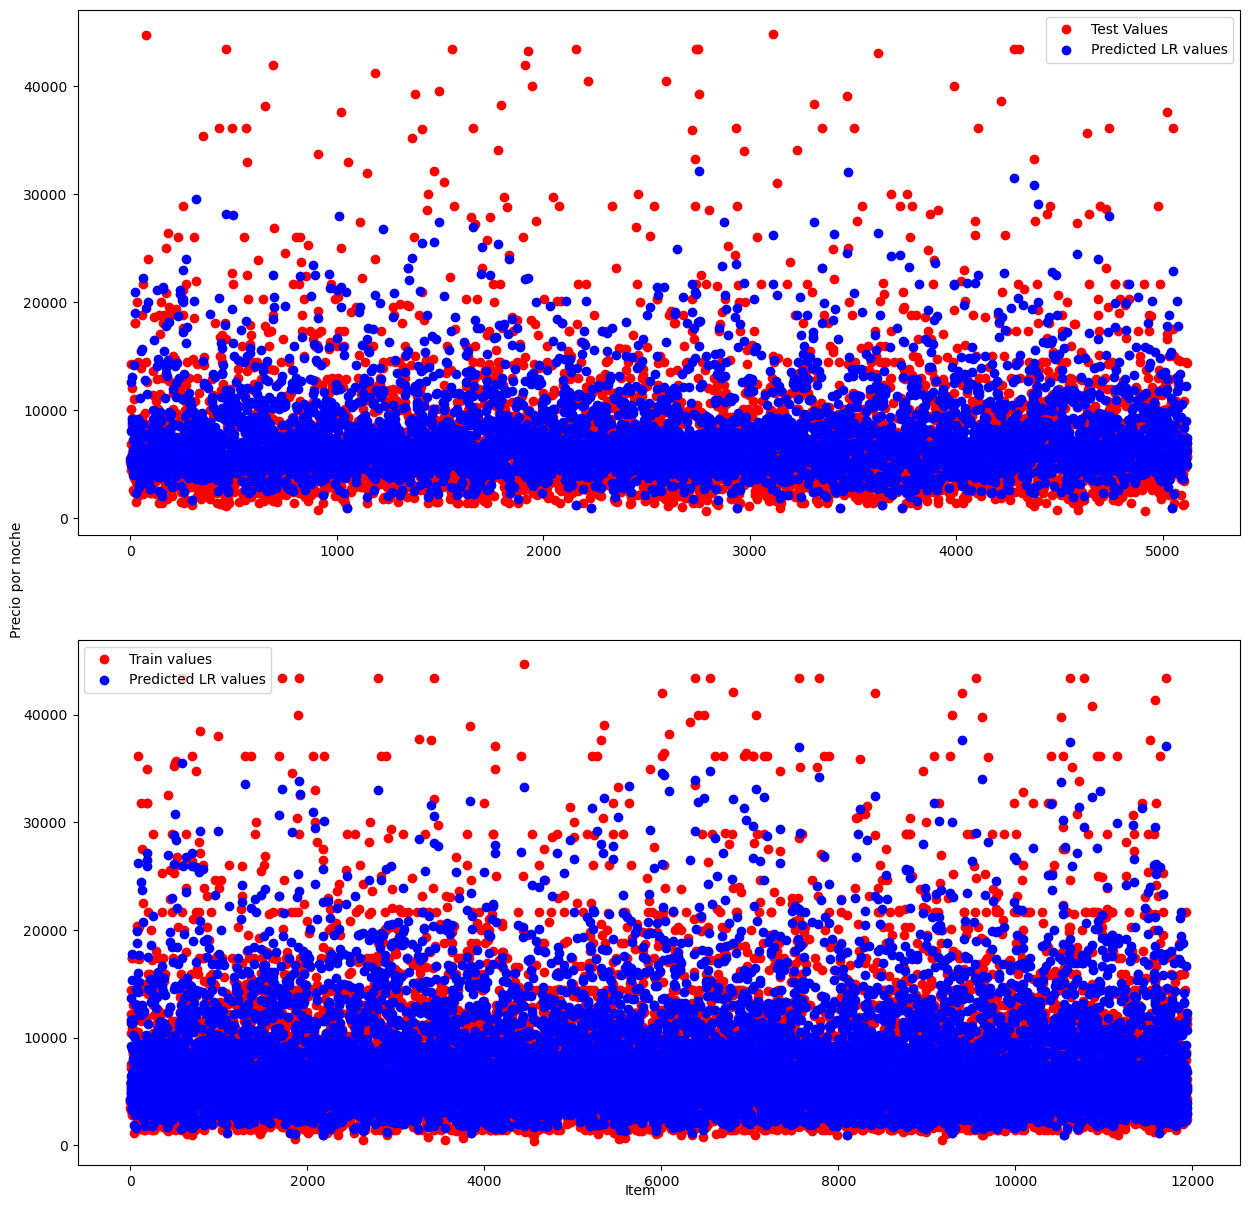

In [10]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_test_rfr_preds, 'bo', label="Predicted LR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_train_rfr_preds, 'bo', label="Predicted LR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

Text(0.5, 1.0, 'CABA feature importances')

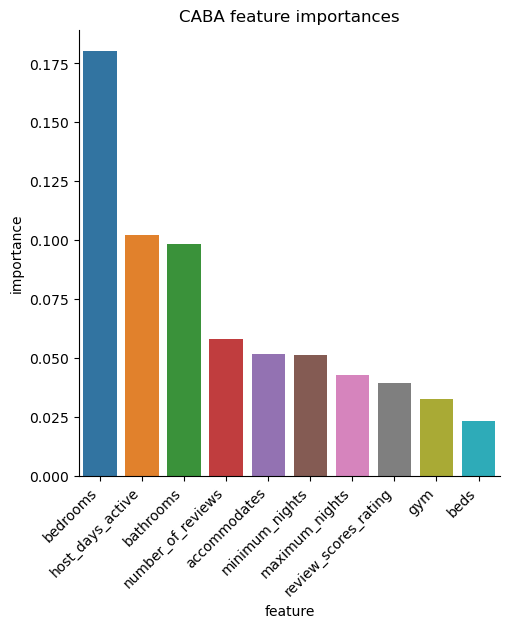

In [11]:
#Feature importancies ranking plot foSeattle's reviews¶
importances = regressor_rfr.feature_importances_
feat_names = X.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = sns.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort)
chart.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title(label= "CABA feature importances", fontdict=None, loc='center', pad=None)

### XGBoost Regressor

In [12]:
params_xgb = {  
    "n_estimators": [2000], 
    "max_depth": [7,8], 
    "learning_rate": [0.01],  
}

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model, param_grid=params_xgb, cv=cv, verbose=1, n_jobs=-1)
xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
          

In [13]:
xgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 2000}

In [14]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
y_pred_test_xg = xgb_grid.best_estimator_.predict(X_test)

mse_xg = np.round(mean_squared_error(y_test, y_pred_test_xg),3)
rmse_xg = np.round(np.sqrt(mse_xg),3)
mae_xg = np.round(mean_absolute_error(y_test, y_pred_test_xg),3)
r2_xg =  r2_score(y_test, y_pred_test_xg)

print('---- TEST ---')
print('MAE   :', mae_xg)
print('MSE   :', mse_xg)
print('RMSE  :', rmse_xg)
print('R^2 = :', r2_xg)


y_pred_train_xg = xgb_grid.best_estimator_.predict(X_train)

mse_xg = np.round(mean_squared_error(y_train, y_pred_train_xg),3)
rmse_xg = np.round(np.sqrt(mse_xg),3)
mae_xg = np.round(mean_absolute_error(y_train, y_pred_train_xg),3)
r2_xg =  r2_score(y_train, y_pred_train_xg)

print('---- TRAIN ---')
print('MAE   :', mae_xg)
print('MSE   :', mse_xg)
print('RMSE  :', rmse_xg)
print('R^2 = :', r2_xg)

---- TEST ---
MAE   : 2441.395
MSE   : 16268824.64
RMSE  : 4033.463
R^2 = : 0.4886210207416074
---- TRAIN ---
MAE   : 1686.633
MSE   : 6784260.25
RMSE  : 2604.661
R^2 = : 0.7745882982215214


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


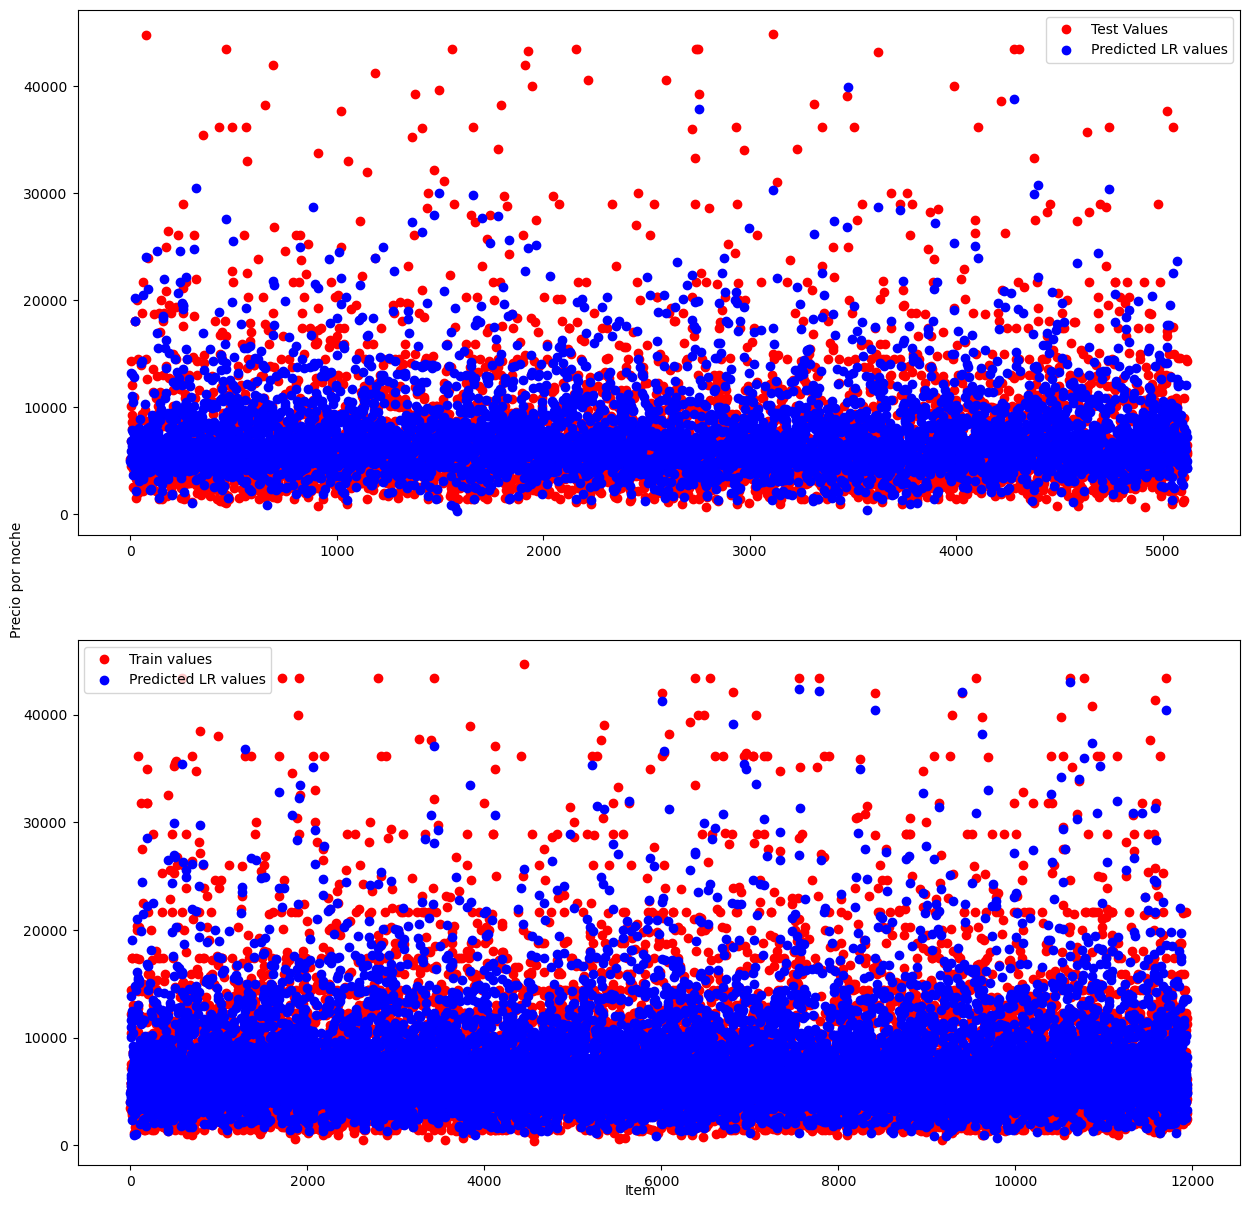

In [16]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_pred_test_xg, 'bo', label="Predicted LR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_pred_train_xg, 'bo', label="Predicted LR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

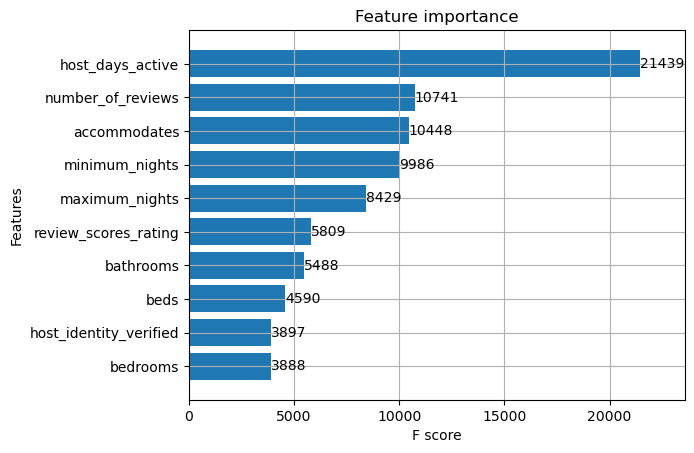

In [17]:
from xgboost import plot_importance
plot_importance(xgb_grid.best_estimator_, height = 0.8,max_num_features=10);

### LGBM

In [18]:

params_lgb = {  
    "n_estimators": [2000,4000], 
    "max_depth": [8], 
    "learning_rate": [0.01],  
}

lgb_model = lgb.LGBMRegressor()
lgb_grid = GridSearchCV(lgb_model, param_grid=params_lgb, cv=cv, verbose=1, n_jobs=-1)
lgb_grid.fit(X_train,y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [8],
                         'n_estimators': [2000, 4000]},
             verbose=1)

In [19]:
lgb_grid.best_params_

{'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 2000}

In [21]:
y_pred_test_xg = lgb_grid.best_estimator_.predict(X_test)

mse_xg = np.round(mean_squared_error(y_test, y_pred_test_xg),3)
rmse_xg = np.round(np.sqrt(mse_xg),3)
mae_xg = np.round(mean_absolute_error(y_test, y_pred_test_xg),3)
r2_xg =  r2_score(y_test, y_pred_test_xg)

print('---- TEST ---')
print('MAE   :', mae_xg)
print('MSE   :', mse_xg)
print('RMSE  :', rmse_xg)
print('R^2 = :', r2_xg)


y_pred_train_xg = lgb_grid.best_estimator_.predict(X_train)

mse_xg = np.round(mean_squared_error(y_train, y_pred_train_xg),3)
rmse_xg = np.round(np.sqrt(mse_xg),3)
mae_xg = np.round(mean_absolute_error(y_train, y_pred_train_xg),3)
r2_xg =  r2_score(y_train, y_pred_train_xg)

print('---- TRAIN ---')
print('MAE   :', mae_xg)
print('MSE   :', mse_xg)
print('RMSE  :', rmse_xg)
print('R^2 = :', r2_xg)

---- TEST ---
MAE   : 2461.768
MSE   : 16325694.037
RMSE  : 4040.507
R^2 = : 0.4868334414493951
---- TRAIN ---
MAE   : 1958.792
MSE   : 9637442.157
RMSE  : 3104.423
R^2 = : 0.6797893716904982


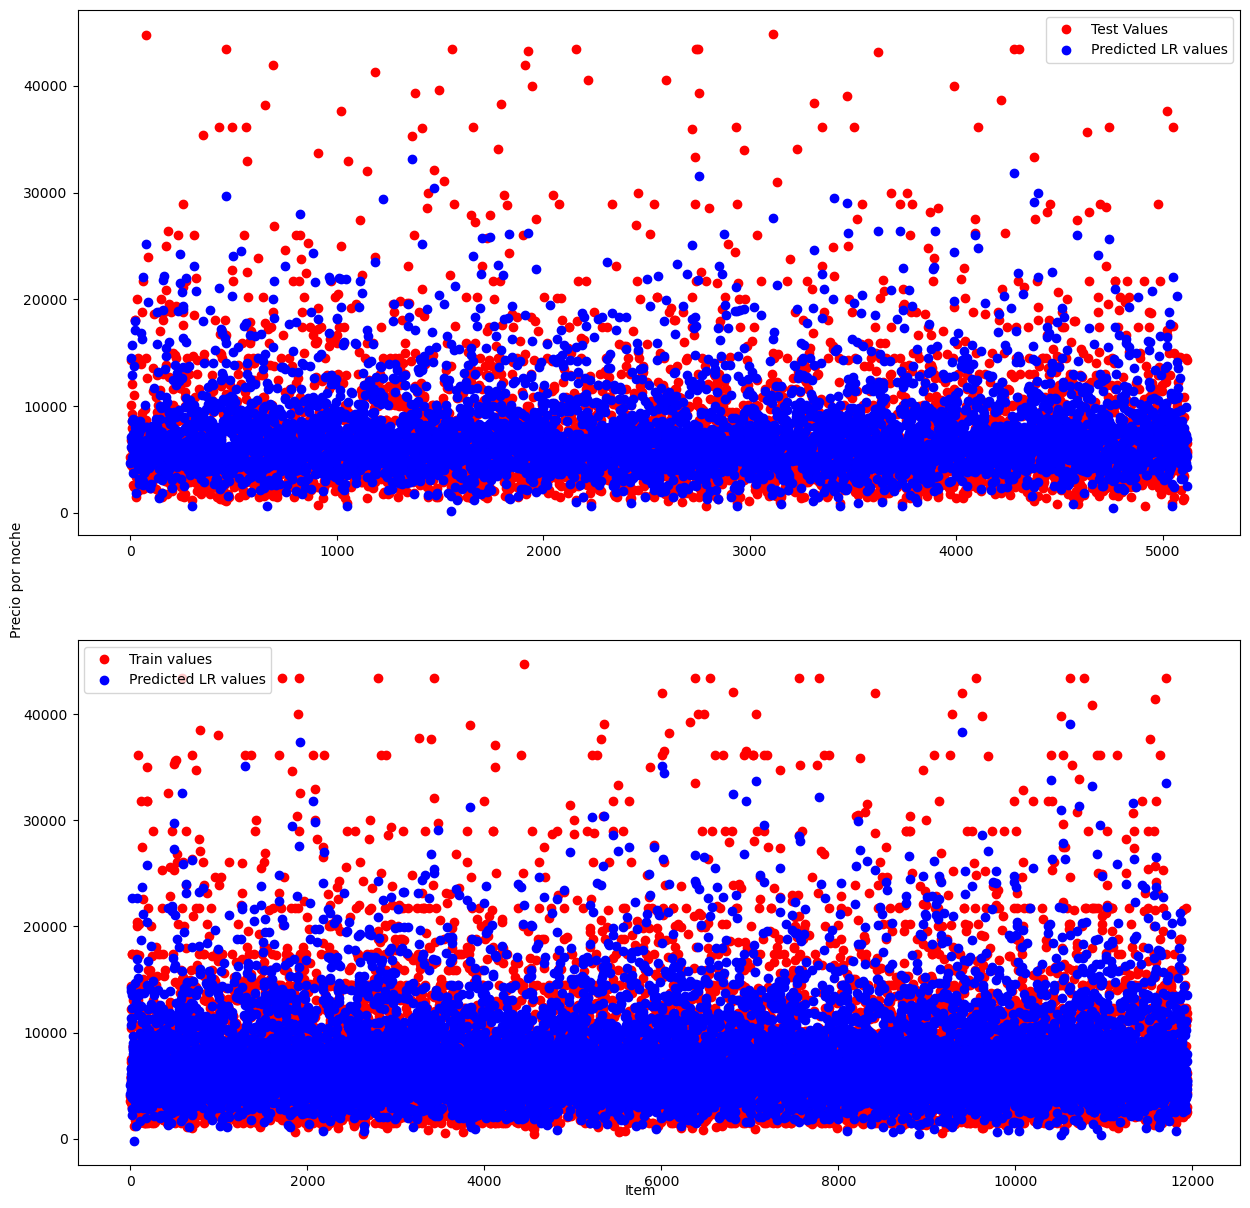

In [22]:
#Gráfico de los valores vs los predecidos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

axes[0].plot([i for i in range(len(y_test))],y_test, 'ro', label="Test Values")
axes[0].plot([i for i in range(len(y_test))],y_test_lgb_preds, 'bo', label="Predicted LR values")
axes[0].legend()

axes[1].plot([i for i in range(len(y_train))],y_train, 'ro', label="Train values")
axes[1].plot([i for i in range(len(y_train))],y_train_lgb_preds, 'bo', label="Predicted LR values")
axes[1].legend()

fig.text(0.5, 0.09, 'Item', ha='center')
fig.text(0.08, 0.5, 'Precio por noche', va='center', rotation='vertical')
plt.show()

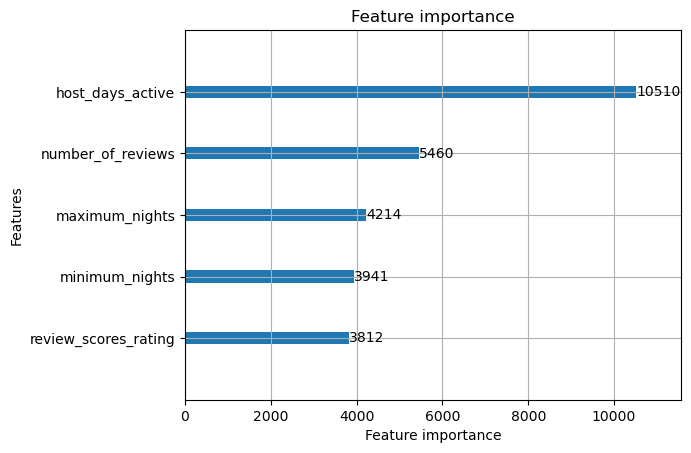

/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/docker/.co

In [23]:
lgb.plot_importance(lgb_grid.best_estimator_, max_num_features=5);

In [24]:
joblib.dump(xgb_grid.best_estimator_,'model.sav')

['model.sav']